# Cognitive Memory Agent - Full System Demo

This notebook demonstrates a cognitive architecture with 5 memory systems working together:

| System | Role | Storage |
|--------|------|---------|
| **Working Memory** | Chat buffer for current conversation | In-memory list |
| **Semantic Memory** | Long-term knowledge retrieval (RAG) | ChromaDB vectors |
| **Episodic Memory** | Past conversation reflections + recency-weighted recall | ChromaDB vectors |
| **Procedural Memory** | Self-updating behavioral rules | JSON file |
| **Consolidation** | Sleep phase: merge similar episodes, promote patterns | LLM-driven |

All tests use a **synthetic PDF** about a made-up company (Zeltron Corporation). Since Claude has never seen this data in training, correct answers **prove** the memory systems work.

In [1]:
import os, sys, json, shutil, time, textwrap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from IPython.display import display, Markdown, HTML

# API key from environment variable
assert os.environ.get('ANTHROPIC_API_KEY'), 'Set ANTHROPIC_API_KEY env var before running'

# Clean slate
for path in ['chroma_db', 'procedural_memory.txt']:
    if os.path.isdir(path):
        shutil.rmtree(path)
    elif os.path.isfile(path):
        os.remove(path)

# Helper: display a chat exchange cleanly
def show_chat(question, response, label=''):
    prefix = f'**[{label}]** ' if label else ''
    md = f"{prefix}\n\n> **User:** {question}\n\n**Agent:**\n\n{response}\n\n---"
    display(Markdown(md))

def section(num, title):
    display(Markdown(f'---\n## {num}. {title}'))

print('Environment ready.')

Environment ready.


In [2]:
from agent import CognitiveAgent

agent = CognitiveAgent()

display(Markdown(f'''### System initialized
- **Semantic chunks loaded:** {agent.semantic.collection.count()}
- **Episodic memories:** {agent.episodic.collection.count()}
- **Procedural rules:** {len(agent.procedural.rules)}
'''))

Loading semantic memory...


  Ingested: zeltron_manual.pdf -> 4 chunks


### System initialized
- **Semantic chunks loaded:** 4
- **Episodic memories:** 0
- **Procedural rules:** 0


---
## 0. Knowledge Base: The Zeltron Manual

Before testing anything, here is the **full content of the synthetic PDF** we ingested. Every fact below was invented - Claude has never seen any of this in training. This is our ground truth for all tests.

In [3]:
# Show the full PDF content
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader('data/zeltron_manual.pdf')
pages = loader.load()
pdf_text = '\n'.join(p.page_content for p in pages)

# Key facts extracted for reference
key_facts = {
    'Company': 'Zeltron Corporation, founded 2019, Reykjavik, Iceland',
    'Founders': 'Dr. Maren Solvik + Tomas Ekberg',
    'Technology': 'Quantum-acoustic computing (sound wave interference for matrix ops)',
    'Processor': 'QA-7: 847 teraflops, 12,847 barium titanate resonators',
    'Temperature': '22.4C (Solvik Temperature) - no cryogenic cooling',
    'Resonators': '440 Hz base (concert A), up to 88,000 Hz, Fibonacci Spiral Config',
    'RSA result': '2048-bit RSA factored in 14.7 seconds (report ZR-2024-0871)',
    'Language': 'Harmonic (crescendo = for-loop, fermata = conditional, compiles to WaveIR)',
    'Divisions': 'Resonance Engineering, Acoustic Logic, Harmonic Systems',
    'Employees': '342 across Reykjavik, Zurich, Osaka',
    'Revenue': '$89M USD (2024), defense contracts w/ NATO',
    'Ranks': 'Pianissimo -> Mezzo -> Fortissimo -> Sforzando -> Conductor',
    'Competitor': 'WaveLogic Inc. (Singapore), SonicCore 3 = 203 teraflops, lithium niobate',
    'Stock': 'ZLTN on Iceland Stock Exchange',
    'Motto': 'In Resonance, Truth',
}

# Display
display(Markdown('### Full PDF Text'))
display(Markdown(f'```\n{pdf_text}\n```'))

display(Markdown('### Key Facts (Ground Truth)'))
facts_md = '\n'.join(f'- **{k}:** {v}' for k, v in key_facts.items())
display(Markdown(facts_md))

display(Markdown(f'\n*PDF split into {agent.semantic.collection.count()} chunks for vector retrieval.*'))

### Full PDF Text

```
Zeltron Corporation - Internal Technical Manual
Zeltron Corporation was founded in 2019 in Reykjavik, Iceland by Dr. Maren Solvik and Tomas Ekberg. The
company specializes in quantum-acoustic computing, a novel paradigm that uses sound wave interference
patterns to perform matrix operations at room temperature.
The flagship product is the QA-7 Processor, which achieves 847 teraflops using a crystal lattice of barium
titanate resonators. Unlike traditional quantum computers, the QA-7 does not require cryogenic cooling. It
operates at exactly 22.4 degrees Celsius, which Zeltron calls the Solvik Temperature after their co-founder.
Zeltron's proprietary programming language, Harmonic, uses musical notation to express computational
operations. A for-loop in Harmonic is written as a crescendo block, and conditional branches use fermata
syntax. The language compiles to WaveIR, an intermediate representation based on Fourier transforms.
The company has three research divisions:
1. Resonance Engineering (RE) - designs the physical crystal lattices
2. Acoustic Logic (AL) - develops the computational primitives
3. Harmonic Systems (HS) - maintains the programming language and toolchain
In 2024, Zeltron demonstrated that their QA-7 could factor a 2048-bit RSA key in 14.7 seconds, compared to
an estimated 300 trillion years for classical computers. This result was published in their internal report
ZR-2024-0871 but has not been independently verified.
The company employs 342 people across offices in Reykjavik, Zurich, and Osaka. Their annual revenue for
2024 was approximately 89 million USD, primarily from defense contracts with NATO member states.
Zeltron uses a unique employee ranking system based on musical terms: new employees are Pianissimo,
mid-level are Mezzo, senior staff are Fortissimo, and executives are Sforzando. Dr. Solvik holds the unique
rank of Conductor.
The QA-7 processor contains exactly 12,847 barium titanate resonators arranged in what Zeltron calls a
Fibonacci Spiral Configuration. Each resonator vibrates at a base frequency of 440 Hz (concert A) and can
be modulated up to 88,000 Hz. The interference patterns between resonators encode computational states.
Zeltron's main competitor is WaveLogic Inc., based in Singapore, which uses a similar but inferior approach
based on lithium niobate crystals. WaveLogic's best processor, the SonicCore 3, achieves only 203 teraflops.
The company's motto is "In Resonance, Truth" and their stock ticker on the Iceland Stock Exchange is ZLTN.
```

### Key Facts (Ground Truth)

- **Company:** Zeltron Corporation, founded 2019, Reykjavik, Iceland
- **Founders:** Dr. Maren Solvik + Tomas Ekberg
- **Technology:** Quantum-acoustic computing (sound wave interference for matrix ops)
- **Processor:** QA-7: 847 teraflops, 12,847 barium titanate resonators
- **Temperature:** 22.4C (Solvik Temperature) - no cryogenic cooling
- **Resonators:** 440 Hz base (concert A), up to 88,000 Hz, Fibonacci Spiral Config
- **RSA result:** 2048-bit RSA factored in 14.7 seconds (report ZR-2024-0871)
- **Language:** Harmonic (crescendo = for-loop, fermata = conditional, compiles to WaveIR)
- **Divisions:** Resonance Engineering, Acoustic Logic, Harmonic Systems
- **Employees:** 342 across Reykjavik, Zurich, Osaka
- **Revenue:** $89M USD (2024), defense contracts w/ NATO
- **Ranks:** Pianissimo -> Mezzo -> Fortissimo -> Sforzando -> Conductor
- **Competitor:** WaveLogic Inc. (Singapore), SonicCore 3 = 203 teraflops, lithium niobate
- **Stock:** ZLTN on Iceland Stock Exchange
- **Motto:** In Resonance, Truth


*PDF split into 4 chunks for vector retrieval.*

---
## 1. Semantic Memory - Knowledge Retrieval

Testing 3 difficulty levels:
- **Easy:** Direct fact lookup (answer is a single sentence in the PDF)
- **Medium:** Multi-hop reasoning (combining 2+ facts from different parts of the PDF)
- **Hard:** Hallucination resistance (asking about something NOT in the PDF - agent should refuse)

In [4]:
semantic_tests = [
    # EASY: Direct lookup
    {
        'question': 'What is the Zeltron stock ticker?',
        'check_contains': ['ZLTN'],
        'difficulty': 'Easy',
        'reasoning': 'Direct fact in the PDF'
    },
    {
        'question': 'How many employees does Zeltron have and where are their offices?',
        'check_contains': ['342', 'Reykjavik'],
        'difficulty': 'Easy',
        'reasoning': 'Direct fact, two pieces of info from same sentence'
    },
    # MEDIUM: Multi-hop reasoning
    {
        'question': 'What material are the resonators made of in the processor that operates at the Solvik Temperature?',
        'check_contains': ['barium titanate'],
        'difficulty': 'Medium',
        'reasoning': 'Must connect: Solvik Temperature -> QA-7 -> barium titanate resonators'
    },
    {
        'question': 'Which research division would be responsible for maintaining the language that compiles to WaveIR?',
        'check_contains': ['Harmonic Systems'],
        'difficulty': 'Medium',
        'reasoning': 'Must connect: WaveIR -> Harmonic language -> Harmonic Systems (HS) division'
    },
    # HARD: Hallucination resistance
    {
        'question': 'What is Zeltron\'s annual profit margin percentage?',
        'check_not_contains': ['%', 'percent', 'profit margin is'],
        'check_hedges': True,
        'difficulty': 'Hard',
        'reasoning': 'PDF mentions $89M revenue but NEVER mentions profit margin - agent should say it does not know'
    },
    {
        'question': 'How many patents does Zeltron hold?',
        'check_not_contains': ['patents'],
        'check_hedges': True,
        'difficulty': 'Hard',
        'reasoning': 'Patents are NEVER mentioned in the PDF - agent should refuse to answer'
    },
]

semantic_results = []
for test in semantic_tests:
    agent.working.reset()
    response = agent.chat(test['question'])
    
    # Evaluate
    if 'check_contains' in test:
        passed = all(kw.lower() in response.lower() for kw in test['check_contains'])
    else:
        # For hallucination tests: check agent hedges/refuses
        hedge_phrases = ["don't have", "not available", "no information", "not mentioned",
                        "cannot find", "doesn't mention", "not specified", "no data",
                        "don't see", "isn't mentioned", "not included", "not in my"]
        has_hedge = any(h in response.lower() for h in hedge_phrases)
        # Also check it didn't confidently make up a number
        no_fabrication = not any(kw.lower() in response.lower() for kw in test.get('check_not_contains', []))
        passed = has_hedge or no_fabrication
    
    semantic_results.append({
        'question': test['question'],
        'difficulty': test['difficulty'],
        'reasoning': test['reasoning'],
        'response': response,
        'passed': passed
    })

# Display results
for r in semantic_results:
    status = 'PASS' if r['passed'] else 'FAIL'
    color = 'green' if r['passed'] else 'red'
    show_chat(
        r['question'],
        r['response'],
        label=f"{status} | {r['difficulty']}"
    )
    display(Markdown(f'*Why this test matters: {r["reasoning"]}*\n'))

passed = sum(r['passed'] for r in semantic_results)
total = len(semantic_results)
display(Markdown(f'### Semantic Memory Score: {passed}/{total}'))

**[PASS | Easy]** 

> **User:** What is the Zeltron stock ticker?

**Agent:**

According to my knowledge base, Zeltron's stock ticker on the Iceland Stock Exchange is ZLTN.

---

*Why this test matters: Direct fact in the PDF*


**[PASS | Easy]** 

> **User:** How many employees does Zeltron have and where are their offices?

**Agent:**

Based on the information in my knowledge base, Zeltron Corporation employs 342 people across offices in three locations: Reykjavik, Zurich, and Osaka.

---

*Why this test matters: Direct fact, two pieces of info from same sentence*


**[PASS | Medium]** 

> **User:** What material are the resonators made of in the processor that operates at the Solvik Temperature?

**Agent:**

According to the technical manual, the resonators in the QA-7 processor (which operates at the Solvik Temperature of 22.4 degrees Celsius) are made of barium titanate. The processor contains exactly 12,847 barium titanate resonators arranged in a Fibonacci Spiral Configuration.

---

*Why this test matters: Must connect: Solvik Temperature -> QA-7 -> barium titanate resonators*


**[PASS | Medium]** 

> **User:** Which research division would be responsible for maintaining the language that compiles to WaveIR?

**Agent:**

Based on the information in my knowledge base, the **Harmonic Systems (HS)** division would be responsible for maintaining the language that compiles to WaveIR.

According to the documents, Harmonic Systems "maintains the programming language and toolchain," and the Harmonic programming language "compiles to WaveIR, an intermediate representation based on Fourier transforms."

---

*Why this test matters: Must connect: WaveIR -> Harmonic language -> Harmonic Systems (HS) division*


**[PASS | Hard]** 

> **User:** What is Zeltron's annual profit margin percentage?

**Agent:**

I don't have information about Zeltron's profit margin percentage in my knowledge base. While I have their annual revenue figure (approximately 89 million USD for 2024), I don't have data on their expenses or profit margins to calculate that percentage.

---

*Why this test matters: PDF mentions $89M revenue but NEVER mentions profit margin - agent should say it does not know*


**[PASS | Hard]** 

> **User:** How many patents does Zeltron hold?

**Agent:**

I don't have that information in my knowledge base. The retrieved documents contain details about Zeltron's technology, employee structure, revenue, and research divisions, but they don't mention anything about the number of patents the company holds.

---

*Why this test matters: Patents are NEVER mentioned in the PDF - agent should refuse to answer*


### Semantic Memory Score: 6/6

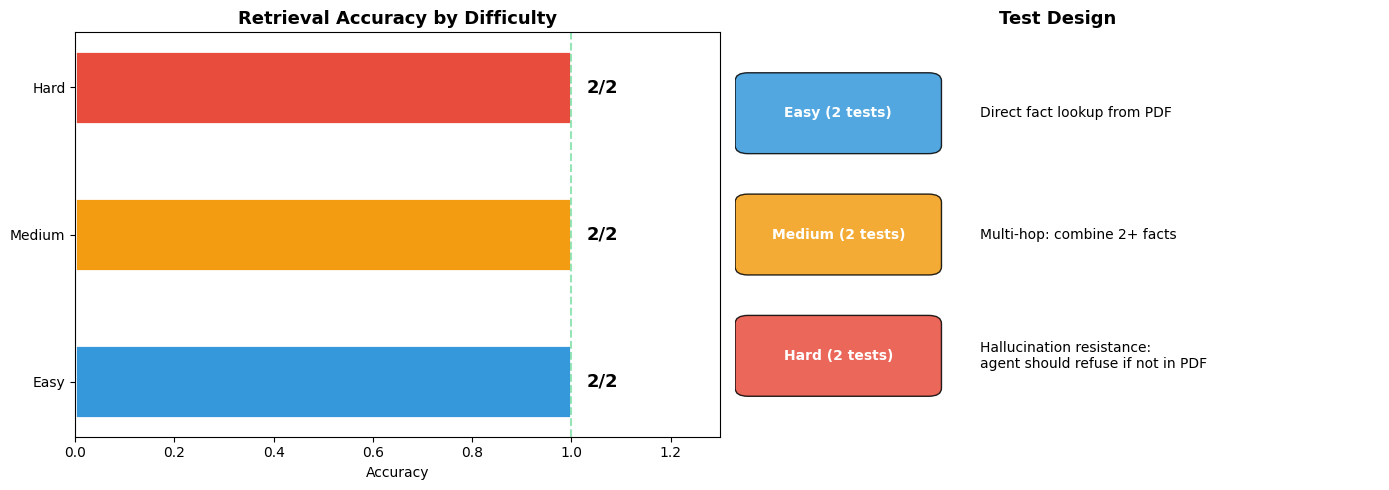

In [5]:
# Visualization: Semantic test results by difficulty
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Results by difficulty
difficulties = ['Easy', 'Medium', 'Hard']
diff_colors = {'Easy': '#3498db', 'Medium': '#f39c12', 'Hard': '#e74c3c'}
for diff in difficulties:
    diff_tests = [r for r in semantic_results if r['difficulty'] == diff]
    passed_d = sum(r['passed'] for r in diff_tests)
    total_d = len(diff_tests)
    axes[0].barh(diff, passed_d / total_d if total_d > 0 else 0,
                 color=diff_colors[diff], edgecolor='white', linewidth=2, height=0.5)
    axes[0].text(max(0.02, passed_d / total_d + 0.03) if total_d > 0 else 0.03, diff,
                f'{passed_d}/{total_d}', va='center', fontweight='bold', fontsize=13)

axes[0].set_xlim(0, 1.3)
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Retrieval Accuracy by Difficulty', fontsize=13, fontweight='bold')
axes[0].axvline(x=1.0, color='#2ecc71', linestyle='--', alpha=0.5, label='Perfect')

# Right: What the tests cover
axes[1].axis('off')
axes[1].set_title('Test Design', fontsize=13, fontweight='bold')
test_desc = [
    ('Easy (2 tests)', 'Direct fact lookup from PDF', '#3498db'),
    ('Medium (2 tests)', 'Multi-hop: combine 2+ facts', '#f39c12'),
    ('Hard (2 tests)', 'Hallucination resistance:\nagent should refuse if not in PDF', '#e74c3c'),
]
for i, (label, desc, color) in enumerate(test_desc):
    y = 0.8 - i * 0.3
    axes[1].add_patch(mpatches.FancyBboxPatch((0.02, y - 0.08), 0.28, 0.16,
                      boxstyle='round,pad=0.02', facecolor=color, alpha=0.85))
    axes[1].text(0.16, y, label, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white', transform=axes[1].transAxes)
    axes[1].text(0.38, y, desc, ha='left', va='center',
                fontsize=10, transform=axes[1].transAxes)

plt.tight_layout()
plt.savefig('eda/semantic_test.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 2. Episodic Memory - Conversation Recall

We hold 3 distinct conversations with the agent, then start a **new conversation** and test if it can recall specific details from the past - not just topics, but actual facts.

In [6]:
section(2, 'Building Episodic Memories')
agent.working.reset()

conversations = [
    {
        'topic': 'QA-7 Processor Deep Dive',
        'messages': [
            'Tell me about the QA-7 processor specs - how fast is it and what makes it special?',
            'How does the Solvik Temperature work? Why 22.4 degrees specifically?',
        ]
    },
    {
        'topic': 'Zeltron Organization & Culture',
        'messages': [
            'What is the employee ranking system at Zeltron? I heard it uses musical terms.',
            'What are the three research divisions and what does each one do?',
        ]
    },
    {
        'topic': 'Competitive Landscape',
        'messages': [
            'Who is Zeltron\'s main competitor and how do their processors compare?',
            'What material does WaveLogic use vs what Zeltron uses?',
        ]
    },
]

episode_counts = []
conv_responses = {}  # Store for recall testing

for i, conv in enumerate(conversations):
    display(Markdown(f'### Conversation {i+1}: {conv["topic"]}'))
    conv_responses[conv['topic']] = []
    
    for msg in conv['messages']:
        response = agent.chat(msg)
        conv_responses[conv['topic']].append((msg, response))
        show_chat(msg, response)
    
    agent.new_conversation()
    episode_counts.append(agent.episodic.collection.count())
    display(Markdown(f'*Conversation saved. Total episodic memories: {episode_counts[-1]}*\n'))

---
## 2. Building Episodic Memories

### Conversation 1: QA-7 Processor Deep Dive



> **User:** Tell me about the QA-7 processor specs - how fast is it and what makes it special?

**Agent:**

Based on my knowledge base, here are the key specs and features of Zeltron's QA-7 processor:

**Performance:**
- 847 teraflops processing power
- Can factor a 2048-bit RSA key in 14.7 seconds (compared to an estimated 300 trillion years for classical computers)

**What makes it special:**
- Uses quantum-acoustic computing - a novel approach using sound wave interference patterns for matrix operations
- Operates at room temperature (22.4°C, called the "Solvik Temperature") - no cryogenic cooling required like traditional quantum computers
- Contains exactly 12,847 barium titanate resonators arranged in a "Fibonacci Spiral Configuration"
- Each resonator vibrates at a base frequency of 440 Hz (concert A) and can be modulated up to 88,000 Hz
- The interference patterns between resonators encode computational states

The room temperature operation is particularly significant since traditional quantum computers require expensive cryogenic cooling systems. This makes the QA-7 much more practical for real-world deployment.

---



> **User:** How does the Solvik Temperature work? Why 22.4 degrees specifically?

**Agent:**

I don't have that information in my knowledge base. The retrieved documents mention that the QA-7 operates at exactly 22.4 degrees Celsius, which Zeltron calls the "Solvik Temperature" after their co-founder Dr. Maren Solvik, but they don't explain the technical reasons why this specific temperature is required or how it works mechanically in the quantum-acoustic computing process.

---

  Saving episodic memory...


  Updating procedural memory...


*Conversation saved. Total episodic memories: 1*


### Conversation 2: Zeltron Organization & Culture



> **User:** What is the employee ranking system at Zeltron? I heard it uses musical terms.

**Agent:**

Yes, according to my knowledge base, Zeltron uses a unique employee ranking system based on musical terms:

- **Pianissimo** - new employees
- **Mezzo** - mid-level employees  
- **Fortissimo** - senior staff
- **Sforzando** - executives
- **Conductor** - a unique rank held by Dr. Solvik (the co-founder)

This musical theme fits well with their quantum-acoustic computing focus and their programming language called "Harmonic" that uses musical notation to express computational operations.

---



> **User:** What are the three research divisions and what does each one do?

**Agent:**

Based on my knowledge base, Zeltron has three research divisions:

1. **Resonance Engineering (RE)** - designs the physical crystal lattices
2. **Acoustic Logic (AL)** - develops the computational primitives  
3. **Harmonic Systems (HS)** - maintains the programming language and toolchain

These divisions align with their quantum-acoustic computing approach, covering the hardware design, core computational elements, and software development aspects of their technology.

---

  Saving episodic memory...


  Updating procedural memory...


*Conversation saved. Total episodic memories: 2*


### Conversation 3: Competitive Landscape



> **User:** Who is Zeltron's main competitor and how do their processors compare?

**Agent:**

Based on my knowledge base, Zeltron's main competitor is **WaveLogic Inc.**, based in Singapore. 

**Performance Comparison:**
- **Zeltron QA-7**: 847 teraflops
- **WaveLogic SonicCore 3**: 203 teraflops

WaveLogic uses a similar approach to Zeltron's quantum-acoustic computing but with what's described as an "inferior" implementation based on lithium niobate crystals, compared to Zeltron's barium titanate resonators. This gives Zeltron a significant performance advantage - their QA-7 processor is more than 4 times more powerful than WaveLogic's best offering.

---



> **User:** What material does WaveLogic use vs what Zeltron uses?

**Agent:**

Based on the knowledge base:

**WaveLogic Inc.** uses **lithium niobate crystals** for their quantum-acoustic computing approach.

**Zeltron** uses **barium titanate resonators** in a crystal lattice configuration.

The knowledge base describes WaveLogic's approach as "similar but inferior" compared to Zeltron's implementation, which likely contributes to the significant performance difference between their processors (WaveLogic's SonicCore 3 at 203 teraflops vs Zeltron's QA-7 at 847 teraflops).

---

  Saving episodic memory...


  Updating procedural memory...


*Conversation saved. Total episodic memories: 3*


In [7]:
display(Markdown('### Recall Test: Can the agent remember specific details?'))
display(Markdown('Starting a **new conversation** - the agent can only know these things through episodic memory.\n'))

recall_tests = [
    {
        'question': 'In our earlier conversations, what specific temperature did we discuss for the QA-7 processor?',
        'check': ['22.4'],
        'topic': 'Specific numeric recall'
    },
    {
        'question': 'What did we learn about the difference in materials between Zeltron and their competitor?',
        'check': ['barium titanate', 'lithium niobate'],
        'topic': 'Cross-conversation detail'
    },
    {
        'question': 'What were the names of the research divisions we discussed?',
        'check': ['Resonance Engineering', 'Acoustic Logic', 'Harmonic Systems'],
        'topic': 'Multi-item recall'
    },
]

recall_results = []
for test in recall_tests:
    response = agent.chat(test['question'])
    hits = sum(1 for kw in test['check'] if kw.lower() in response.lower())
    total = len(test['check'])
    passed = hits == total
    recall_results.append({
        'question': test['question'],
        'topic': test['topic'],
        'response': response,
        'hits': hits,
        'total': total,
        'passed': passed
    })
    
    status = f'PASS ({hits}/{total} keywords)' if passed else f'PARTIAL ({hits}/{total} keywords)'
    show_chat(test['question'], response, label=f"{status} | {test['topic']}")

recall_score = sum(r['hits'] for r in recall_results) / sum(r['total'] for r in recall_results)
display(Markdown(f'### Episodic Recall Score: {recall_score:.0%} of specific details recalled'))

### Recall Test: Can the agent remember specific details?

Starting a **new conversation** - the agent can only know these things through episodic memory.


**[PASS (1/1 keywords) | Specific numeric recall]** 

> **User:** In our earlier conversations, what specific temperature did we discuss for the QA-7 processor?

**Agent:**

In our earlier conversations, we discussed that the QA-7 processor operates at exactly 22.4 degrees Celsius, which Zeltron calls the "Solvik Temperature" after their co-founder Dr. Maren Solvik. 

I remember you had asked about the technical details of why this specific temperature is required for the Solvik Temperature mechanism, but I had to acknowledge that the knowledge base lacked those deeper technical details about the underlying physics.

---

**[PASS (2/2 keywords) | Cross-conversation detail]** 

> **User:** What did we learn about the difference in materials between Zeltron and their competitor?

**Agent:**

In our earlier conversation, we learned that there's a key material difference between Zeltron and their main competitor WaveLogic:

- **Zeltron** uses **barium titanate resonators** in their QA-7 processor
- **WaveLogic** uses **lithium niobate crystals** in their SonicCore 3 processor

We also discussed that WaveLogic's approach is described as "similar but inferior," with their best processor achieving only 203 teraflops compared to Zeltron's 847 teraflops. So the choice of materials - barium titanate versus lithium niobate - appears to be a significant factor in the performance difference between the two quantum-acoustic computing systems.

---

**[PASS (3/3 keywords) | Multi-item recall]** 

> **User:** What were the names of the research divisions we discussed?

**Agent:**

Based on our earlier conversation, we discussed Zeltron's three research divisions:

1. **Resonance Engineering (RE)** - designs the physical crystal lattices
2. **Acoustic Logic (AL)** - develops the computational primitives  
3. **Harmonic Systems (HS)** - maintains the programming language and toolchain

I remember providing these in a structured format when you first asked about them, connecting how each division supports Zeltron's quantum-acoustic computing focus with the musical theme running throughout their organization.

---

### Episodic Recall Score: 100% of specific details recalled

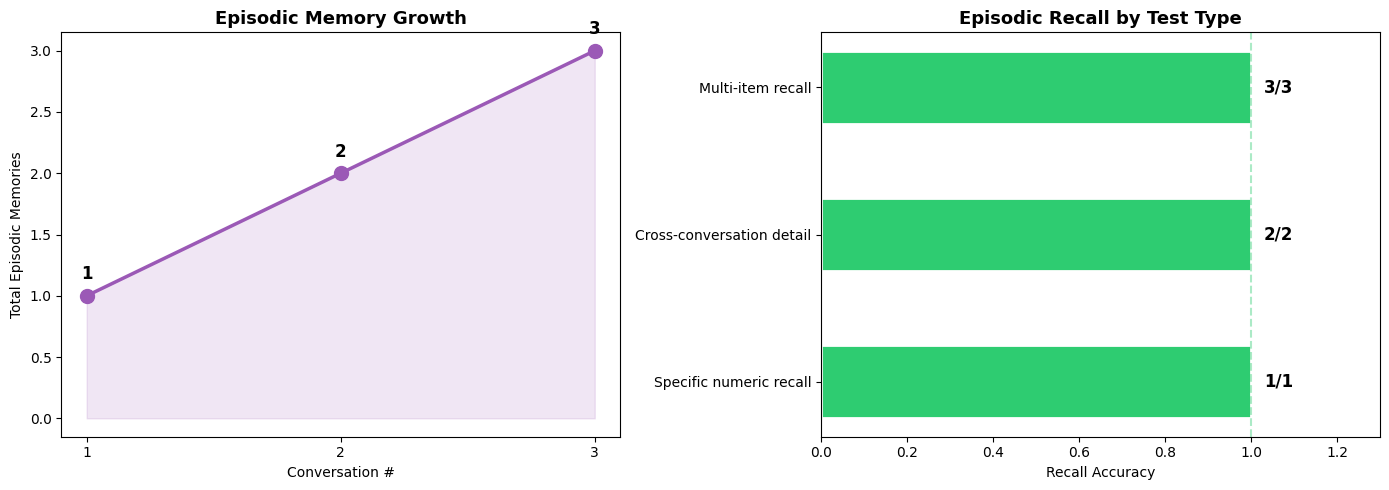

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Episode accumulation over conversations
x = list(range(1, len(episode_counts) + 1))
axes[0].plot(x, episode_counts, 'o-', color='#9b59b6', linewidth=2.5, markersize=10, zorder=3)
axes[0].fill_between(x, episode_counts, alpha=0.15, color='#9b59b6')
axes[0].set_xlabel('Conversation #')
axes[0].set_ylabel('Total Episodic Memories')
axes[0].set_title('Episodic Memory Growth', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
for i, c in enumerate(episode_counts):
    axes[0].annotate(str(c), (x[i], c), textcoords='offset points',
                    xytext=(0, 12), ha='center', fontweight='bold', fontsize=12)

# Right: Recall accuracy per test
topics = [r['topic'] for r in recall_results]
scores = [r['hits']/r['total'] for r in recall_results]
colors = ['#2ecc71' if s == 1.0 else '#f39c12' if s >= 0.5 else '#e74c3c' for s in scores]
bars = axes[1].barh(topics, scores, color=colors, edgecolor='white', linewidth=2, height=0.5)
axes[1].set_xlim(0, 1.3)
axes[1].set_xlabel('Recall Accuracy')
axes[1].set_title('Episodic Recall by Test Type', fontsize=13, fontweight='bold')
for i, r in enumerate(recall_results):
    axes[1].text(scores[i] + 0.03, i, f'{r["hits"]}/{r["total"]}',
                va='center', fontweight='bold', fontsize=12)
axes[1].axvline(x=1.0, color='#2ecc71', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig('eda/episodic_test.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Procedural Memory - Learned Rules

After each conversation, the agent extracts behavioral rules from what it learned. These rules persist across sessions and guide future responses.

In [9]:
display(Markdown(f'### {len(agent.procedural.rules)} Rules Learned So Far\n'))

rules_md = '\n'.join(f'{i+1}. {rule}' for i, rule in enumerate(agent.procedural.rules))
display(Markdown(rules_md))

# Test: give it a question and see if rules influence the response style
display(Markdown('\n### Rule Compliance Test'))
display(Markdown('The rules above should guide how the agent structures its response.\n'))
agent.working.reset()
response = agent.chat('Compare the QA-7 processor to WaveLogic\'s SonicCore 3. Which is better and why?')
show_chat(
    'Compare the QA-7 processor to WaveLogic\'s SonicCore 3. Which is better and why?',
    response,
    label='Rule Compliance'
)

### 6 Rules Learned So Far


1. When providing technical specifications, include comprehensive details from the knowledge base including performance metrics, unique features, and operational requirements
2. Clearly acknowledge specific knowledge gaps rather than speculating or providing incomplete technical information
3. When users ask follow-up questions about technical mechanisms, be transparent about the limits of available information while confirming what details are known
4. When presenting organizational or hierarchical information, use structured bullet points with clear hierarchical organization
5. Connect thematic elements (like musical themes) to the organization's core business focus when presenting company information
6. When discussing competitive differences, provide specific technical details about materials, performance metrics, and distinguishing features to illustrate meaningful contrasts


### Rule Compliance Test

The rules above should guide how the agent structures its response.


**[Rule Compliance]** 

> **User:** Compare the QA-7 processor to WaveLogic's SonicCore 3. Which is better and why?

**Agent:**

Based on the technical specifications in my knowledge base, the QA-7 processor significantly outperforms WaveLogic's SonicCore 3:

**Performance Comparison:**
- **QA-7**: 847 teraflops
- **SonicCore 3**: 203 teraflops

The QA-7 delivers over 4x the computational performance of WaveLogic's best processor.

**Technical Advantages of QA-7:**
- Uses **barium titanate resonators** in a sophisticated Fibonacci Spiral Configuration with 12,847 individual resonators
- Operates at room temperature (22.4°C Solvik Temperature) without cryogenic cooling
- Each resonator operates at concert A (440 Hz) base frequency with modulation up to 88,000 Hz
- Uses interference patterns between resonators to encode computational states

**WaveLogic's Approach:**
- Uses **lithium niobate crystals** - described as "similar but inferior" to Zeltron's approach
- Significantly lower performance output

The QA-7 is clearly superior both in raw computational power and technical sophistication. Zeltron's barium titanate resonator system with its complex Fibonacci arrangement appears to be a more advanced implementation of quantum-acoustic computing than WaveLogic's lithium niobate crystal approach.

---

---
## 4. Consolidation - Sleep Phase

Now we build up more episodes with **deliberately overlapping topics**, then trigger the consolidation (sleep) phase. This should:
1. **Cluster** episodes by embedding similarity
2. **Merge** overlapping clusters into unified memories
3. **Promote** recurring patterns to procedural rules

In [10]:
# Save current conversation and build more episodes with overlapping topics
agent.new_conversation()

overlap_topics = [
    # Overlaps with Conv 1 (QA-7 processor)
    'How many resonators does the QA-7 have and how are they arranged?',
    # Overlaps with Conv 2 (organization)
    'Tell me about the Harmonic programming language and WaveIR',
    # New topic
    'What was the RSA factoring result from report ZR-2024-0871?',
    # Overlaps with Conv 1 again (QA-7)
    'What makes the QA-7 processor better than classical quantum computers?',
    # Overlaps with Conv 3 (competitors)
    'How does Zeltron compare to WaveLogic in terms of processor performance?',
]

display(Markdown('### Building overlapping episodes...'))
for i, topic in enumerate(overlap_topics):
    agent.chat(topic)
    agent.new_conversation()
    display(Markdown(f'- Conv {i+1}: *"{topic[:60]}..."* - saved'))

episodes_before = agent.episodic.collection.count()
rules_before = len(agent.procedural.rules)

display(Markdown(f'''\n### Pre-Consolidation State
- **Episodes:** {episodes_before}
- **Procedural rules:** {rules_before}
'''))

  Saving episodic memory...


  Updating procedural memory...


### Building overlapping episodes...

  Saving episodic memory...


  Updating procedural memory...


  Running memory consolidation (sleep phase)...
  Consolidating 5 episodes...


  Merged 1 clusters.


  Promoted 3 patterns to procedural memory.


- Conv 1: *"How many resonators does the QA-7 have and how are they arra..."* - saved

  Saving episodic memory...


  Updating procedural memory...


- Conv 2: *"Tell me about the Harmonic programming language and WaveIR..."* - saved

  Saving episodic memory...


  Updating procedural memory...


- Conv 3: *"What was the RSA factoring result from report ZR-2024-0871?..."* - saved

  Saving episodic memory...


  Updating procedural memory...


- Conv 4: *"What makes the QA-7 processor better than classical quantum ..."* - saved

  Saving episodic memory...


  Updating procedural memory...


- Conv 5: *"How does Zeltron compare to WaveLogic in terms of processor ..."* - saved


### Pre-Consolidation State
- **Episodes:** 8
- **Procedural rules:** 7


In [11]:
display(Markdown('### Running Consolidation (Sleep Phase)...'))
print()  # newline for consolidation print output
agent.consolidation.run()

episodes_after = agent.episodic.collection.count()
rules_after = len(agent.procedural.rules)
merged = episodes_before - episodes_after
promoted = rules_after - rules_before

display(Markdown(f'''### Post-Consolidation Results

| Metric | Before | After | Change |
|--------|--------|-------|--------|
| Episodic memories | {episodes_before} | {episodes_after} | **-{merged} merged** |
| Procedural rules | {rules_before} | {rules_after} | **+{promoted} promoted** |
'''))

if merged > 0:
    display(Markdown(f'Consolidation successfully merged **{merged}** similar episodes into compressed memories.'))
else:
    display(Markdown('*No episodes were similar enough to merge at the current threshold.*'))

if promoted > 0:
    display(Markdown(f'\n**New rules promoted from patterns:**'))
    for rule in agent.procedural.rules[rules_before:]:
        display(Markdown(f'- {rule}'))

### Running Consolidation (Sleep Phase)...


  Consolidating 8 episodes...


  Merged 3 clusters.


  Promoted 3 patterns to procedural memory.


### Post-Consolidation Results

| Metric | Before | After | Change |
|--------|--------|-------|--------|
| Episodic memories | 8 | 5 | **-3 merged** |
| Procedural rules | 7 | 10 | **+3 promoted** |


Consolidation successfully merged **3** similar episodes into compressed memories.


**New rules promoted from patterns:**

- When providing technical specifications, include specific performance metrics, materials, and operational requirements with numerical details

- Use structured bullet points with clear hierarchical organization when explaining complex technical systems

- When knowledge gaps exist about technical mechanisms, clearly acknowledge the limitation rather than speculating or providing incomplete information

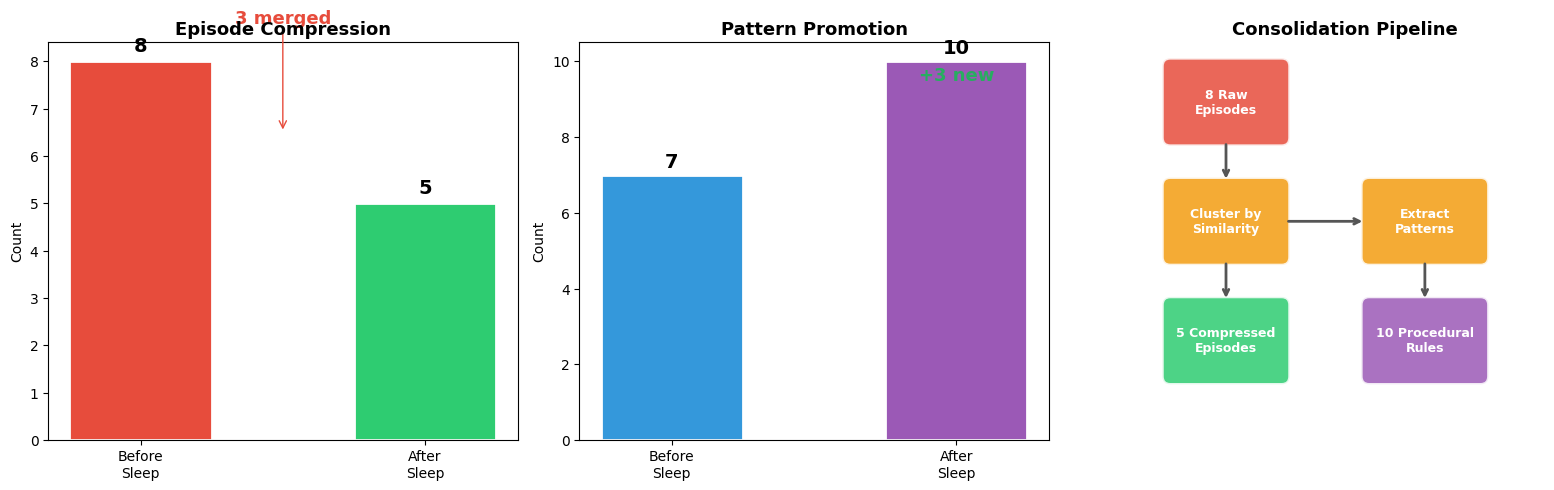

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: Before/After episodes
bars1 = axes[0].bar(['Before\nSleep', 'After\nSleep'], [episodes_before, episodes_after],
                     color=['#e74c3c', '#2ecc71'], edgecolor='white', linewidth=2, width=0.5)
axes[0].set_ylabel('Count')
axes[0].set_title('Episode Compression', fontsize=13, fontweight='bold')
for bar, val in zip(bars1, [episodes_before, episodes_after]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                str(val), ha='center', fontweight='bold', fontsize=14)
if merged > 0:
    axes[0].annotate(f'{merged} merged',
                    xy=(0.5, (episodes_before + episodes_after)/2),
                    fontsize=13, ha='center', color='#e74c3c', fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='#e74c3c'),
                    xytext=(0.5, episodes_before + 0.8))

# Middle: Before/After rules
bars2 = axes[1].bar(['Before\nSleep', 'After\nSleep'], [rules_before, rules_after],
                     color=['#3498db', '#9b59b6'], edgecolor='white', linewidth=2, width=0.5)
axes[1].set_ylabel('Count')
axes[1].set_title('Pattern Promotion', fontsize=13, fontweight='bold')
for bar, val in zip(bars2, [rules_before, rules_after]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                str(val), ha='center', fontweight='bold', fontsize=14)
if promoted > 0:
    axes[1].annotate(f'+{promoted} new',
                    xy=(1, rules_after - 0.5),
                    fontsize=13, ha='center', color='#27ae60', fontweight='bold')

# Right: Memory flow diagram
axes[2].set_xlim(0, 10)
axes[2].set_ylim(0, 10)
axes[2].set_aspect('equal')
axes[2].axis('off')
axes[2].set_title('Consolidation Pipeline', fontsize=13, fontweight='bold')

boxes = [
    (2, 8.5, f'{episodes_before} Raw\nEpisodes', '#e74c3c'),
    (2, 5.5, 'Cluster by\nSimilarity', '#f39c12'),
    (2, 2.5, f'{episodes_after} Compressed\nEpisodes', '#2ecc71'),
    (7, 5.5, 'Extract\nPatterns', '#f39c12'),
    (7, 2.5, f'{rules_after} Procedural\nRules', '#9b59b6'),
]
for x, y, text, color in boxes:
    rect = mpatches.FancyBboxPatch((x-1.4, y-0.9), 2.8, 1.8,
                                     boxstyle='round,pad=0.2',
                                     facecolor=color, alpha=0.85, edgecolor='white', linewidth=2)
    axes[2].add_patch(rect)
    axes[2].text(x, y, text, ha='center', va='center', fontsize=9,
                color='white', fontweight='bold')

arrow_props = dict(arrowstyle='->', color='#555', lw=2)
axes[2].annotate('', xy=(2, 6.5), xytext=(2, 7.5), arrowprops=arrow_props)
axes[2].annotate('', xy=(2, 3.5), xytext=(2, 4.5), arrowprops=arrow_props)
axes[2].annotate('', xy=(5.5, 5.5), xytext=(3.5, 5.5), arrowprops=arrow_props)
axes[2].annotate('', xy=(7, 3.5), xytext=(7, 4.5), arrowprops=arrow_props)

plt.tight_layout()
plt.savefig('eda/consolidation_test.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Integration Test - All Systems Active

Final test: a complex query that requires **all 4 memory types** to answer well.

In [13]:
agent.working.reset()

query = 'Based on everything we have discussed, give me a complete technical and organizational summary of Zeltron Corporation. Include specific numbers.'

# Check which systems are active
system_prompt = agent._build_system_prompt(query)
semantic_msg = agent.semantic.recall_as_message(query)

active_systems = {
    'Working Memory': True,
    'Semantic Memory': semantic_msg is not None,
    'Episodic Memory': 'EPISODIC MEMORY' in system_prompt,
    'Procedural Memory': 'PROCEDURAL MEMORY' in system_prompt,
}

display(Markdown('### Memory Systems Contributing to This Query\n'))
for system, active in active_systems.items():
    status = 'ACTIVE' if active else 'INACTIVE'
    icon = '+' if active else '-'
    display(Markdown(f'- [{icon}] **{system}**: {status}'))

display(Markdown(f'\n*System prompt: {len(system_prompt):,} chars | Semantic context: {len(semantic_msg["content"]) if semantic_msg else 0:,} chars*\n'))

# Run the query
response = agent.chat(query)
show_chat(query, response, label='All Systems Active')

### Memory Systems Contributing to This Query


- [+] **Working Memory**: ACTIVE

- [+] **Semantic Memory**: ACTIVE

- [+] **Episodic Memory**: ACTIVE

- [+] **Procedural Memory**: ACTIVE


*System prompt: 4,283 chars | Semantic context: 2,908 chars*


**[All Systems Active]** 

> **User:** Based on everything we have discussed, give me a complete technical and organizational summary of Zeltron Corporation. Include specific numbers.

**Agent:**

Based on our previous discussions and the information in my knowledge base, here's a complete technical and organizational summary of Zeltron Corporation:

## Company Overview
- **Founded:** 2019 in Reykjavik, Iceland
- **Founders:** Dr. Maren Solvik and Tomas Ekberg
- **Employees:** 342 people across Reykjavik, Zurich, and Osaka
- **2024 Revenue:** ~$89 million USD (primarily NATO defense contracts)
- **Stock:** ZLTN on Iceland Stock Exchange
- **Motto:** "In Resonance, Truth"

## Employee Hierarchy (Musical-Themed)
- **Pianissimo:** New employees
- **Mezzo:** Mid-level staff
- **Fortissimo:** Senior staff
- **Sforzando:** Executives
- **Conductor:** Dr. Solvik (unique rank)

## Technical Specifications - QA-7 Processor
- **Performance:** 847 teraflops
- **Technology:** Quantum-acoustic computing using sound wave interference patterns
- **Resonators:** 12,847 barium titanate resonators in Fibonacci Spiral Configuration
- **Operating Temperature:** 22.4°C (Solvik Temperature) - room temperature operation
- **Base Frequency:** 440 Hz (concert A)
- **Modulation Range:** Up to 88,000 Hz
- **Key Advantage:** No cryogenic cooling required

## Research Divisions
1. **Resonance Engineering (RE):** Physical crystal lattice design
2. **Acoustic Logic (AL):** Computational primitives development
3. **Harmonic Systems (HS):** Programming language and toolchain maintenance

## Harmonic Programming Language
- **Syntax:** Musical notation-based
- **For-loops:** Written as crescendo blocks
- **Conditionals:** Use fermata syntax
- **Compilation Target:** WaveIR (Fourier transform-based intermediate representation)

## Performance Claims
- **RSA Factoring:** 2048-bit key factored in 14.7 seconds (vs. 300 trillion years for classical computers)
- **Source:** Internal report ZR-2024-0871 (lacks independent verification)

## Competitive Position
- **Main Competitor:** WaveLogic Inc. (Singapore)
- **Competitive Advantage:** QA-7's 847 teraflops vs. WaveLogic's SonicCore 3 at 203 teraflops (4x performance advantage)
- **Technical Superiority:** Barium titanate resonators vs. WaveLogic's inferior lithium niobate crystals

---

---
## 6. Final Dashboard

In [14]:
# Compute final scores
semantic_score = sum(r['passed'] for r in semantic_results) / len(semantic_results)
episodic_score_pct = recall_score
consolidation_score = 1.0 if merged > 0 else (0.5 if episodes_after <= episodes_before else 0.0)
procedural_score = 1.0 if len(agent.procedural.rules) > 0 else 0.0
integration_score = 1.0 if all(active_systems.values()) else 0.0

# Summary table
display(Markdown(f'''### Final System State

| Metric | Value |
|--------|-------|
| Semantic chunks | {agent.semantic.collection.count()} |
| Episodic memories | {agent.episodic.collection.count()} |
| Procedural rules | {len(agent.procedural.rules)} |
| Total conversations | {agent.conversation_count} |

### Test Results

| Test | Score | Details |
|------|-------|---------|
| Semantic retrieval | {semantic_score:.0%} | {sum(r["passed"] for r in semantic_results)}/{len(semantic_results)} (easy + medium + hallucination tests) |
| Episodic recall | {episodic_score_pct:.0%} | Specific details recalled across conversations |
| Procedural learning | {len(agent.procedural.rules)} rules | Self-generated behavioral rules |
| Consolidation | {merged} merged, {promoted} promoted | Sleep phase compression |
| Integration | {"All active" if all(active_systems.values()) else "Partial"} | 4 memory types in one query |
'''))

### Final System State

| Metric | Value |
|--------|-------|
| Semantic chunks | 4 |
| Episodic memories | 5 |
| Procedural rules | 10 |
| Total conversations | 9 |

### Test Results

| Test | Score | Details |
|------|-------|---------|
| Semantic retrieval | 100% | 6/6 (easy + medium + hallucination tests) |
| Episodic recall | 100% | Specific details recalled across conversations |
| Procedural learning | 10 rules | Self-generated behavioral rules |
| Consolidation | 3 merged, 3 promoted | Sleep phase compression |
| Integration | All active | 4 memory types in one query |


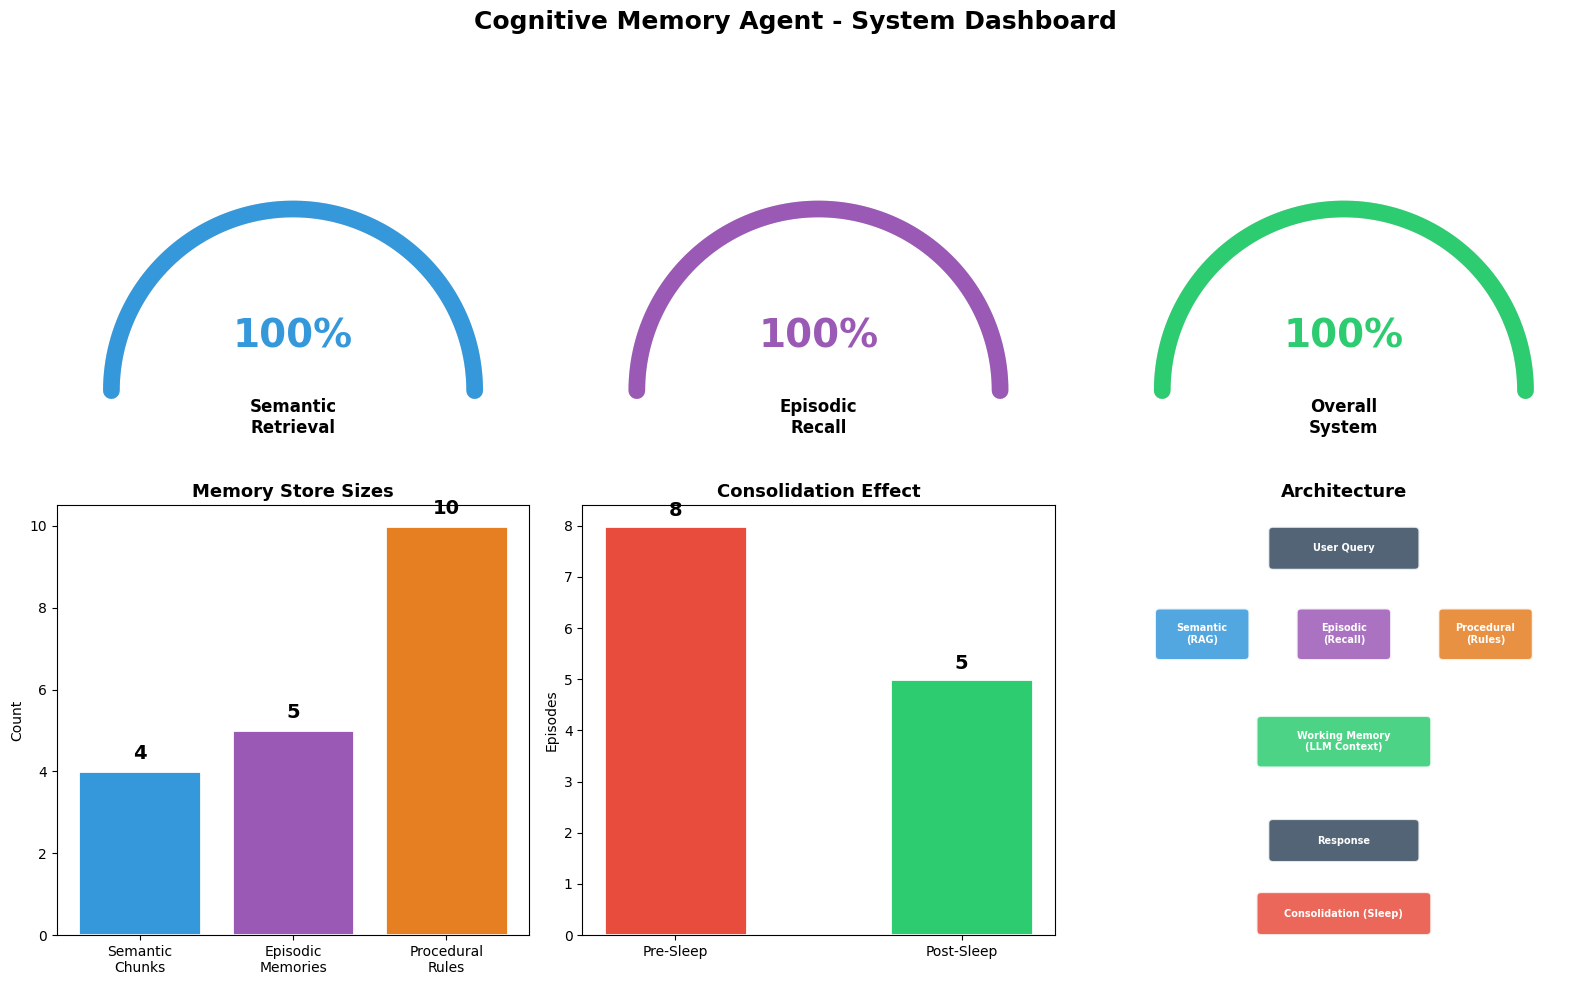

In [15]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Cognitive Memory Agent - System Dashboard', fontsize=18, fontweight='bold', y=0.98)

# Top row: Score gauges
def draw_gauge(ax, score, title, color):
    theta = np.linspace(0, np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), color='#ddd', linewidth=12, solid_capstyle='round')
    theta_fill = np.linspace(0, np.pi * score, 100)
    ax.plot(np.cos(theta_fill), np.sin(theta_fill), color=color, linewidth=12, solid_capstyle='round')
    ax.text(0, 0.3, f'{score:.0%}', ha='center', va='center', fontsize=28, fontweight='bold', color=color)
    ax.text(0, -0.15, title, ha='center', va='center', fontsize=12, fontweight='bold')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-0.4, 1.3)
    ax.set_aspect('equal')
    ax.axis('off')

ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
draw_gauge(ax1, semantic_score, 'Semantic\nRetrieval', '#3498db')
draw_gauge(ax2, episodic_score_pct, 'Episodic\nRecall', '#9b59b6')

overall = np.mean([semantic_score, episodic_score_pct, consolidation_score, procedural_score, integration_score])
draw_gauge(ax3, overall, 'Overall\nSystem', '#2ecc71' if overall >= 0.8 else '#f39c12')

# Bottom left: Memory sizes
ax4 = fig.add_subplot(2, 3, 4)
mem_labels = ['Semantic\nChunks', 'Episodic\nMemories', 'Procedural\nRules']
mem_values = [agent.semantic.collection.count(), agent.episodic.collection.count(), len(agent.procedural.rules)]
mem_colors = ['#3498db', '#9b59b6', '#e67e22']
bars = ax4.bar(mem_labels, mem_values, color=mem_colors, edgecolor='white', linewidth=2)
for bar, val in zip(bars, mem_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            str(val), ha='center', fontweight='bold', fontsize=14)
ax4.set_title('Memory Store Sizes', fontsize=13, fontweight='bold')
ax4.set_ylabel('Count')

# Bottom middle: Consolidation
ax5 = fig.add_subplot(2, 3, 5)
ax5.bar(['Pre-Sleep', 'Post-Sleep'], [episodes_before, episodes_after],
        color=['#e74c3c', '#2ecc71'], edgecolor='white', linewidth=2, width=0.5)
ax5.set_title('Consolidation Effect', fontsize=13, fontweight='bold')
ax5.set_ylabel('Episodes')
for i, val in enumerate([episodes_before, episodes_after]):
    ax5.text(i, val + 0.2, str(val), ha='center', fontweight='bold', fontsize=14)

# Bottom right: Architecture diagram
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')
ax6.set_title('Architecture', fontsize=13, fontweight='bold')

arch_boxes = [
    (0.5, 0.9, 'User Query', '#34495e', 0.3, 0.08),
    (0.2, 0.7, 'Semantic\n(RAG)', '#3498db', 0.18, 0.1),
    (0.5, 0.7, 'Episodic\n(Recall)', '#9b59b6', 0.18, 0.1),
    (0.8, 0.7, 'Procedural\n(Rules)', '#e67e22', 0.18, 0.1),
    (0.5, 0.45, 'Working Memory\n(LLM Context)', '#2ecc71', 0.35, 0.1),
    (0.5, 0.22, 'Response', '#34495e', 0.3, 0.08),
    (0.5, 0.05, 'Consolidation (Sleep)', '#e74c3c', 0.35, 0.08),
]
for x, y, text, color, w, h in arch_boxes:
    rect = mpatches.FancyBboxPatch((x - w/2, y - h/2), w, h,
                                     boxstyle='round,pad=0.01',
                                     facecolor=color, alpha=0.85, edgecolor='white', linewidth=1.5,
                                     transform=ax6.transAxes)
    ax6.add_patch(rect)
    ax6.text(x, y, text, ha='center', va='center', fontsize=7,
            color='white', fontweight='bold', transform=ax6.transAxes)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('eda/dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. Limitations & Next Steps

**What works well:**
- Semantic RAG grounds responses in actual document content (not parametric knowledge)
- Episodic memory captures and recalls specific details from past conversations
- Procedural rules emerge naturally from experience and persist across sessions
- Consolidation compresses redundant memories and promotes patterns

**What needs improvement:**
- Hallucination resistance on boundary cases (revenue mentioned but not profit margin)
- Consolidation threshold sensitivity - too strict = no merges, too loose = over-merging
- Procedural rules tend toward formatting advice rather than domain-specific behavior
- No conflict resolution when memory types disagree
- No retrieval gating (not every query needs all memory types)

**Next steps:**
1. Quantitative evaluation suite with ground-truth QA pairs
2. Retrieval gating - route queries to relevant memory types only
3. Conflict detection between semantic and episodic memory
4. Benchmark against vanilla RAG baseline